# Building classifiers for the Pump It Up project 

We did some initial data prep and eliminated a bunch of columns and did some data type conversions and filled in missing data. See the `data_prep.py` program for the details. In this notebook we will explore a few different classifier methods for this problem, including:

* logistic regression with L1, L2 and elastic-net regularization
* Random forest
* Histogram-based gradient boosting classification tree
* Ensemble models using the above models

In order to use some of these models in sklearn, we will use some of [sklearn's preprocessing tools](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) such as transformers, scaler, imputers and encoders.

We will also use [Pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) objects to chain together multiple modeling steps and streamline our modeling workflow.


## Preliminaries

In [ ]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

Import commonly used libraries and magic command for inline plotting

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [3]:
%matplotlib inline

## Load data from csv

The `data_prep.py` program exported csv and json files. 


In [ ]:
train_X_prep = pd.read_csv('./data/train_x.csv')
test_X_prep = pd.read_csv("./data/test_x.csv")
train_y_prep = pd.read_csv("./data/train_y.csv")

In [ ]:
# drop id col
train_X = train_X_prep.iloc[:, 1:]
test_X = test_X_prep.iloc[:, 1:]
train_y = train_y_prep.iloc[:, 1]

In [ ]:
train_X.info()

In [ ]:
train_X.dtypes

In [ ]:
train_y

## Data preprocessing - variable type lists

In order to use this data in sklearn, there is additional preprocessing that we will have to do. It will end up being useful to have a list of numeric columnss and categorical columns to facilitate preprocessing. The pandas `select_dtypes` method is useful for this - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html.

**NOTE:** Booleans in pandas show as object in `df.info()`. I converted the booleans to strings (ints are ok too) in `data_prep.py`.

In [ ]:
categorical_cols = train_X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train_X.select_dtypes(include=['number']).columns.tolist()

all_cols = train_X.columns.tolist()


In [ ]:
numeric_cols

In [ ]:
categorical_cols

Let's use an *assertion* to make sure we didn't miss any columns. The Python `assert` statement is a way to check that some condition, variable or expression has the desired and expected value. We use assertions quite a bit when we develop formal tests for our code as well as to catch important errors that might happen when our code is run. For example, we might use an assertion to make sure that some important calculation that should only return positive values, does so. The basic form of an assertion is:

    assert some_boolean_expression [, some error message]
    
If the expression is True, nothing happens. But, if it's false an `AssertionError` is raised and Python will print out an error message. This is something we can trap. 

For our current situation, we believe we have classified all columns in our training data as being either categorical or numeric. One simple check would be that the number of entries in the `categorical_cols` list plus the number in the `numeric_cols` list should be equal to the number in the `all_cols` list. In other words...

In [ ]:
assert len(all_cols) == len(categorical_cols) + len(numeric_cols), 'each col should either be in categorical or numeric lists'

When we run the cell above, nothing happens. That's great as it means the condition is true. 

Now let's show what happens if we make a mistake. I'll use new variable names for the demo.

In [ ]:
categorical_cols_demo = train_X.select_dtypes(include=['object']).columns.tolist()
# The next line is WRONG, should be include=['number']
numeric_cols_demo = train_X.select_dtypes(include=['object']).columns.tolist() 

all_cols_demo = train_X.columns.tolist()

# assert len(all_cols_demo) == len(categorical_cols_demo) + len(numeric_cols_demo), 'each col should either be in categorical or numeric lists'

Learn more about assertions and defensive programming from the following Software Carpentry tutorial (part of the Python Programming lesson). You do need to be aware that assertions can be disabled and thus should not be used for critical data or security related validation tasks.

https://swcarpentry.github.io/python-novice-inflammation/10-defensive/index.html

Later we are also going to need the column index numbers for the variables that are categorical. Here's a little list comprehension to do that that uses the column name lists we just created. Note the use of the pandas `get_loc` method which returns the column index for a given column name.

In [ ]:
categorical_cols_idx = [train_X.columns.get_loc(c) for c in categorical_cols]
categorical_cols_idx

**EASY CHALLENGE** Develop a similar list comprehension to get a list of column indexes for the numeric columns.

In [ ]:
# numeric_cols_idx =[WORK SOME MAGIC IN HERE]

This list of indices is helpful for things like the following:

In [ ]:
train_X.iloc[:, categorical_cols_idx].nunique()

## Building a logistic regression classifier

Ok, here we go. There's a lot to digest in this section both with respect to the statistical method itself as well as to using sklearn. As a preview, we will be:

* Reviewing the basics of logistic regression and learning about using *regularization* in our logistic regression models
* Creating data transformers 
* Creating pipelines for transformations and model creation
* Doing data partitioning, model fitting and model scoring
* Gaining some intuition as to how various hyperparameters can affect the modeling process

Some key resources include:

* User Guide: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
* API Docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Our problem is:

* multiclass (not binary) with three classes for our target, the status of the well
* currently, all of the categorical data are strings and sklearn doesn't like strings

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

### Review of logistic regression basics

If you need a refresher on the basics of logistic regression, I'm going to point you to two resources that cover it a level that is appropriate for this class.

* Sections 4.1-4.3 in the [free ISLR book](https://statlearning.com/)
* I've included the knitted HTML version of my logistic regression with R notes in the Downloads file. The filename is `IntroLogisticRegression_Loans_notes.html`. Also, here's the [link to the section of my pcda course website that covers logistic regression](http://www.sba.oakland.edu/faculty/isken/courses/mis5470_w22/modeling2_class_r.html).

A few key points to remember about logistic regression:

* We use it when we have a dependent (target) variable (i.e. the `y` variable) that takes on a fixed number of values. Frequently, our target variable is binary but we can use logistic regression for more than two output values (as in the Pump it Up problem).
* Logistic regression falls within the family of regression models known as General Linear Models (in R, we use the `glm` function to fit these models)
* We can interpret the predicted values from logistic regression models as probabilities and we can then use these probabilities to classify things.
* Whereas in regular old multiple linear regression we can use least squares to find the best fit line (i.e. the values of the coefficients), in logistic regression we can't. Instead we need to use [maximum likelihood estimation](https://online.stat.psu.edu/stat415/lesson/1/1.2) (and [here for a nice video from the StatQuest guy](https://www.youtube.com/watch?v=XepXtl9YKwc)) and for that, various optimization methods are used to find the best values of the model coefficients. It's important to be aware of this since, as we'll see, we actually get to make choices regarding how sklearn solves this optimization problem. 


### Regularization methods for regression modeling

It is not uncommon to have quite a few potential predictor variables when doing regression modeling. Often we might have significant multicollinearity and we can easily create overfitted models whose coefficients have high variance and that don't generalize well to unseen test data. One class of methods for dealing with this are known as *shrinkage methods* or *regularization methods*. It's a bit counterintuitive in that these methods try *shrink* the coefficient values towards zero in a controlled way. By doing this, we end up with a slightly biased model but one that has less variance. These methods can also act as a *variable selection* strategy since they can end up driving some coefficients to zero and essentially dropping them from the model. We won't go deeply into the math but you should have a basic understanding of how these methods work. It's particularly relevant when using logistic regression in sklearn since it **does regularized logistic regression by default** (this is a point of contention among practitioners) and there are some parameters you need to be able to intelligently set.

The three main flavors of regularization that sklearn supports for logistic regression are:

* Ridge regression
* Lasso regression
* Elastic-Net

As we'll see below, each corresponds to a different *penalty function* that we use in the coefficient fitting process.

I've marked up the [Logistic regression page from the sklearn User Guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). 


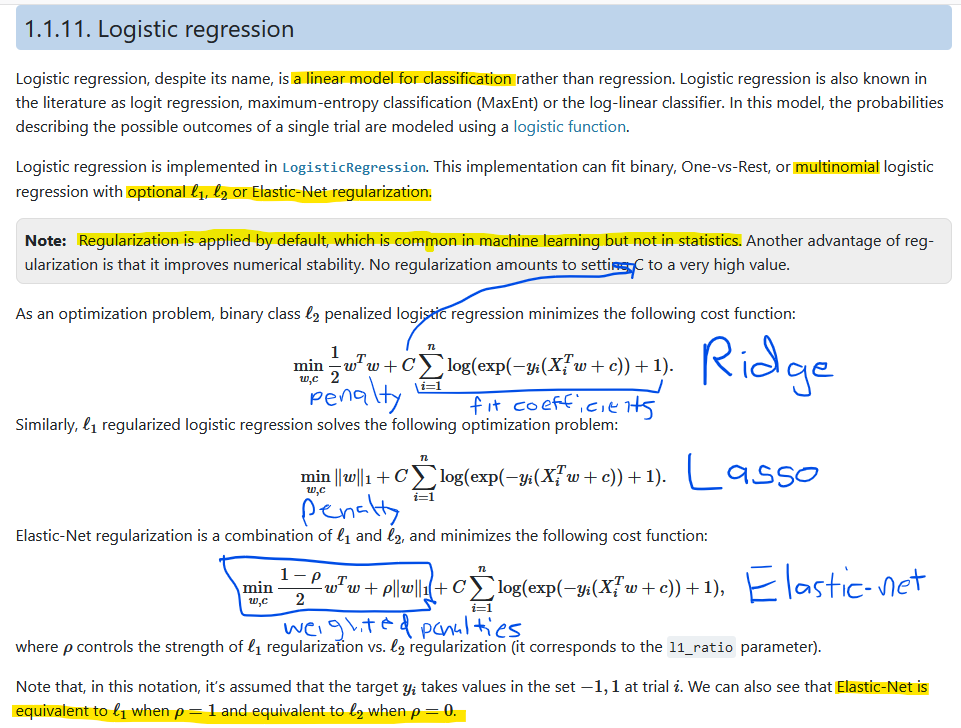

In [4]:
Image('images/regularization_overview.png')

In the sklearn docs, they refer to $\ell_1$ (lasso, and pronouced ell-one), $\ell_2$ (ridge) and Elastic-Net regularization. You'll often see $\ell_1$ and $\ell_2$ written as $L1$ and $L2$ and they refer to quantities known as *norms* of a vector. You can think of them as different ways of measuring the length of a vector. $L2$ is related to Euclidean distance and, in terms of acting as a penalty factor in regression, is proportional to the sum of squares of the coefficients. In the PDSH book, JVP uses $\theta$ to represent the coefficients and $\alpha$ is a hyperparameter that control the relative weight put on the penalty term, $P$.

$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$

In the lasso case, the $L1$ norm is used for the penalty term and you can see it's just the sum of the absolute values of the coefficients (related to Manhattan distance):

$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$

While both of these serve the same basic purpose - shrink the coefficients towards zero, they affect the model fit somewhat differently. For some geometric reasons we won't get into, the lasso penalty will drive a number of coefficients to exactly zero. In essence, it acts a bit like a variable selection method since a zero valued coefficient is the same as dropping the variable from the model. There are pros and cons of each and both require setting the value of the hyperparameter $\alpha$. In practice, cross-validation can be used to find a good value of $\alpha$. You might have noticed that the sklearn `LogisticRegression` function does **not** have an $\alpha$ parameter you can set. Instead you get to set $C$. Notice that all they've done is put the hyperparameter as a multiplier on the residual part of the fitting cost function. So,

* higher values of $C$, means more weight on minimizing residuals and thus, less, regularization (low $\alpha$).
* lower values of $C$ means more weight on the regularization penalty term (high $\alpha$).

In other words, $C$ is an inverse of $\alpha$. In sklearn, the default value of $C$ is 1. We'll play around with different $C$ values to see how they impact the model and later we'll use `LogisticRegressionCV` which will use cross-validation to find the best value of $C$ for our data.

What about this Elastic-Net thing? Well, if we have two different penalty functions to choose from, why not let ourselves use them both? That's all Elastic-Net is doing. You get to set the value of the weight, $\rho$ in the sklearn docs above, that is put on the $L1$ penalty and then $L2$ gets a weight of $1-\rho$. 

**QUESTION** If $\rho = 1$, is that equivalent to $L1$ or $L2$ regularization? And while we are at it, what would you set $C$ to if you didn't want any (or very little) regularization?

**ADDITIONAL RESOURCES**

* Section 6.2 in the ISLR book does a nice job in explaining regularization.
* The PDSH notebook, 05.06-Linear-Regression.ipynb, has a good high level overview of regularization applied to regression. 
* There's a [nice Kaggle post on $L1$ vs $L2$ norms](https://www.kaggle.com/residentmario/l1-norms-versus-l2-norms) in the context of distance metrics and regularization. 

### Building a logistic regression pipeline

In order to use a logistic regression classifier for our Pump it Up problem, we need to do a few steps in succession. At a high level, we need to do the following (many details to worry about in a bit):

1. Do any required data transformations needed to use `LogisticRegression`.
2. Create a `LogisticRegression` model object and set model options.
3. Partition our data into training and test data.
4. Fit the model.
5. Score the model on training and test data.

We'll take a closer look at each of these steps and then we will put them all together. Steps 1 and 2 will become `steps` in an sklearn `Pipeline` object. 


#### Step 1 - Data transformations

Since we are doing regularized logistic regression, the numeric variables should be rescaled so that the units of measurement don't affect the model fitting process. The [sklearn preprocessing module](https://scikit-learn.org/stable/modules/preprocessing.html#) contains a bunch of utility functions for common tasks like this. We will use the [`StandardScalar`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) which will transform numeric variables to have a mean of $0.0$ and a standard deviation of $1.0$. Yes, this puts values on a Z-scale. The `StandardScalar` is an example of a `Transformer` object and, much like we do with `Estimator` objects, we first instantiate a generic object and then later we'll actual use it on our data.

In [ ]:
# Create a StandardScalar object to use on our numeric variables
numeric_transformer = StandardScaler()

For the categorical variables, we need to do something to convert them from strings to numbers since `LogisticRegression` wants a numeric matrix for the predictor variables. If you remember your basic regression modeling, we need to create a set dummy binary variables for each categorical variable. For example, let's say we had a variable named `color` that took on the values 'yellow', 'blue' and 'green'. We could create three dummy variables that we might call, `color_yellow`, `color_blue`, and `color_green`.
Here's a short example.

In [ ]:
color_data_df = pd.DataFrame([{'color': 'blue', 'color_yellow': 0, 'color_blue': 1, 'color_green': 0}, 
                {'color': 'yellow', 'color_yellow': 1, 'color_blue': 0, 'color_green': 0},
                {'color': 'blue', 'color_yellow': 0, 'color_blue': 1, 'color_green': 0},
                {'color': 'green', 'color_yellow': 0, 'color_blue': 0, 'color_green': 1}])

color_data_df

Obviously, after creating the binary variables, the original `color` variable is dropped. You might recall from a basic statistics class that when we do this for a multiple linear regression model, we arbitrarily omit one of the binary variables. We do this for two reasons:

* we can because if we know the value of any two out of the three binary variables, we know the value of the other one (since each row must have a single value of 1),
* in least squares estimation we end up doing a matrix inversion and we don't want to have any variables that are perfect linear combinations of other variables as this can cause numeric instability.

In [ ]:
color_data_df2 = pd.DataFrame([{'color': 'blue', 'color_yellow': 0, 'color_blue': 1}, 
                {'color': 'yellow', 'color_yellow': 1, 'color_blue': 0},
                {'color': 'blue', 'color_yellow': 0, 'color_blue': 1},
                {'color': 'green', 'color_yellow': 0, 'color_blue': 0}])

color_data_df2

**QUESTION** What is the linear equation for `color_green` as a function of `color_yellow` and `color_blue`?

In the machine learning world we often don't have to worry about this issue and will often just fully encode categorical variables with $0$'s and $1$'s. This is known as *one-hot encoding* and sklearn has a transformer object called `OneHotEncoder` to do this.

In [ ]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

So, we have created two transformers, one for our numeric feature variables and one for our categorical feature variables. Both need to be applied to our training and test data. To facilitate this, sklearn provides an estimator called a `ColumnTransformer`. We can use this to bundle multiple transformers together.

https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

Since these two transformers make up all of the things we need to do in our preprocessing step, I'm going to name my `ColumnTransformer` object accordingly. Look closely at what we are passing in to `ColumnTransformer()`.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

We are setting the `transformers` argument to a list of tuples. Each tuple contains:

    (a name we pick for the transformer, the transformer object, which cols to apply this transformer to) 

In [ ]:
Image('images/column_transformer.png')

<div class="alert alert-block alert-warning">
<b>WAIT! What about the target variable? It's a string right now. Don't we have to encode it?</b>
</div>

This actually isn't answered prominently in the User Guide or API docs (afaik - I couldn't find it). But, a little searching led to this SO post in which it's confirmed that sklearn can handle strings for target variable values and it just calls `LabelEncoder` itself if needed to convert the strings to numbers. 

https://stackoverflow.com/questions/50201315/is-numerical-encoding-necessary-for-the-target-variable-in-classification

Also notice the **remainder** parameter. As long as we are careful and don't include the `id` column in either of the variable lists (`numeric_cols` or `categorical_cols`), the transformer can handle automatically not including this variable in any model building. This is convenient since we eventually need the `id` column when creating submission files for the actual Pump it Up competition.

#### Step 2 - Create logistic regression model object

Now that we've built the objects for doing preprocessing (just some data transformations in our case), we will create a logistic regression model object. Remember, this doesn't fit a model - we are just creating an "empty" model object. Well, it's not really empty as we can specify various optional parameter values that will impact the model fitting process down the line.

Let's take a look at the API docs for `LogisticRegression` and discuss the options that we want to set.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In particular, let's focus on:

* there's a lot of talk about *solvers* in the docs; which solver should we use?
* we saw above that there are different regularization methods, each having a different penalty component of the cost function that is being minimized during model fitting (i.e. finding the best coefficient values). Which penalty should we use and how should we set the value of $C$?

Since we are learning about regularization, we want to be able to try all three flavors - ridge, lasso, and Elastic-Net. Notice that the default values are:

* `penalty='l2'` --> ridge
* `C = 1`       --> balanced weights on residuals and regularization penalty
* `solver='lbfgs'` --> it's the default because of its "robustness", according to the sklearn docs

There's a nice table in the [User Guide section on logistic regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that summarizes the capabilities of each solver.

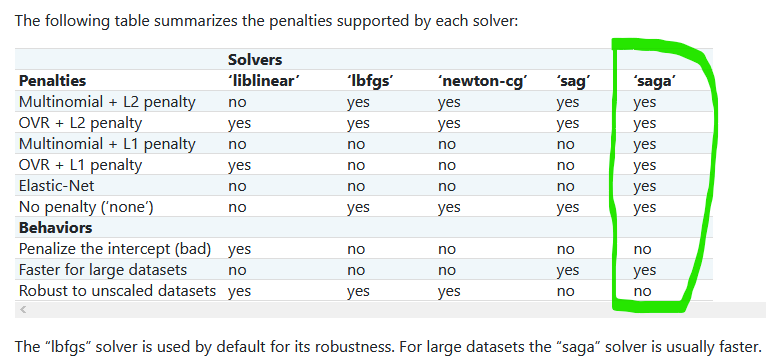

In [5]:
Image('images/penalties.png')

<div class="alert alert-block alert-info">
<b>Learning to read API documentation is a valuable skill. It can often mean the difference between getting something to work and giving up.</b>
</div>

We'll use the 'saga' solver since it's the only one that can do all three penalty types (ridge, lasso and Elastic-Net) and we want to experiment with all of them. Even though some of the values are the defaults, I'm going to explicitly specify them to make things more readable and so we don't have to remember what the defaults are.

In [ ]:
# Classifier model
clf_model = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=500)

#### Creating a Pipeline for Steps 1 and 2
[Pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline) let us chain estimators together. An example might be a sequence of transformations followed by a classifier. A `Pipeline` is made up of `steps`. I'm going to repeat the code we've developed so far and add on the `Pipeline`.

In [ ]:
# Create transformer objects
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Classifier model
clf_model = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model)])

You can even generate a little picture of your pipeline.

In [ ]:
# This is from the new 1.0 ColumnTransformer example. 
from sklearn import set_config

set_config(display='diagram')
clf

#### Steps 3 and 4 - Data partitioning and model fitting

Since we only have target (`y`) data for our training dataset, we'll repartition `train_X` into new training (that we'll call `X_train` and `y_train`) and test datasets for purposes of model fitting and evaluation. For this we can use `sklearn.model_selection.train_test_split`. 

After partitioning the data, we'll fit the model with:

    clf.fit(X_train, y_train)
    
Notice that `clf` is actually our `Pipeline`. This illustrates an advantage of pipelines. We call `fit` one time on the pipeline and it handles the individual fits that happen with the transformers and then the classifier. Makes our code shorter and cleaner.

In [ ]:
# Further partition our training data into train and test sets to use for model fitting and testing

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=14)

# Fit model on new training data - notice that clf is actually the Pipeline
clf.fit(X_train, y_train)

print(f"Training score: {clf.score(X_train, y_train):.3f}")
print(f"Test score: {clf.score(X_test, y_test):.3f}")

Notice that we get a warning that coefficients aren't converging. First of all, what is it that's not converging? It's the *saga* solver. Under the hood, it's just trying to find coefficient values that optimizes the cost function associated with the penalty and the likelihood function. To do this it uses a type of optimization algorithm known as *stochastic gradient descent*. Depending on the details of a specific problem, such algorithms may or may not converge. Even if it doesn't converge the predictions might not be affected very much. For example, perhaps multicollinearity is causing weird oscillations in some coefficients. If it's not converging because it's just taking a long time to converge, we can increase the `max_iter` parameter to make it run longer. If you are interested in the details of stochastic gradient descent, I've included some info at the bottom of this notebook.

Nevertheless, we are getting 0.750 accuracy level on the test data. Pretty unusual to have better performance on test than train but the difference is pretty small. This value is pretty stable no matter what I try for `max_iter`. Got same results with setting `C=1+e2` and `C=1+e1`. Let's try $C<1$. 

In [ ]:
# Classifier model
clf_model_C01 = LogisticRegression(penalty='l2', C=0.01, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
clf_C01 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_C01)])

# Fit model on training data 
clf_C01.fit(X_train, y_train)

print(f"Training score: {clf_C01.score(X_train, y_train):.3f}")
print(f"Test score: {clf_C01.score(X_test, y_test):.3f}")

No convergence issues, but slightly worse performance. You might be thinking that we have quite a few degrees of freedom here with respect to the penalty function used, the hyperparameters ($C$ and for Elastic-Net, $\rho$), the solver, and the number of iterations. Yep. And it can be quite difficult to know what to do in terms of making intelligent choices. That's why **the more you learn about how these statistical and ML algorithms work, the better you'll be in wielding them effectively**. For now, let's table this concern and do a bit more exploring.

Let's try the lasso penalty with $C=0.001$. We are forcing a high level of regularization so that we can look at the coefficients to see if regularization is having an effect on them.

In [ ]:
# Classifier model
clf_model_l1_C001 = LogisticRegression(penalty='l1', C=0.001, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
clf_l1_C001 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_l1_C001)])

# Fit model on training data 
clf_l1_C001.fit(X_train, y_train)

print(f"Training score: {clf_l1_C001.score(X_train, y_train):.3f}")
print(f"Test score: {clf_l1_C001.score(X_test, y_test):.3f}")

Not a big surprise, performance was worse - but that's not the point. Let's see how we can dig the fitted coefficients out of our models so that we can compare the coefficients for the model based on the $L2$ norm and high value of $C$ (low regularization) and the model we just ran with the $L1$ norm and a low value of $C$ (high regularization). 

First things first, how do we get at the coefficient values? The sklearn User Guide explains how to [access steps of a Pipeline](https://scikit-learn.org/stable/modules/compose.html#accessing-steps) and the following StackOverflow post also proved quite useful:

* https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

Since the coefficients are associated with one particular step in our pipeline, we have to use the `named_steps` attribute to get at them. Let's start just by getting their shape. I'll use our first model, the $L2$ norm with $C=1$.

In [ ]:
clf.named_steps['classifier'].coef_.shape

Why do we have three rows of coefficients? We have three possible outcomes for our target variable. For each outcome, we have a logistic regression model with 238 coefficients (!!!). Listing out 238 times 3 coefficents isn't going to be that useful. Let's plot them instead.

Let's adapt JVP's `basis_plot` function from the **05.06-Linear-Regression** notebook.

In [ ]:
clf_l1_C001.steps[1]

In [ ]:
def coef_plot(model, title=None):
    fig, ax = plt.subplots(3, sharex=True)
       
    if title:
        ax[0].set_title(title)

    for i in range(3):
        ax[i].plot(model.steps[1][1].coef_[i])


In [ ]:
coef_plot(clf, 'L2, C=1.0')

Now let's plot the coefficients from the model that used the $L1$ norm and really low value of $C$ (high regularization). We are expecting a lot of the coefficients to get driven to 0. Does that happen?

In [ ]:
coef_plot(clf_l1_C001, 'L1, C=0.001')

I also tried $C=1$ and performance was no better with $L1$ norm. Probably not likely that Elastic-Net will do any better since it's just a weighted average of $L1$ and $L2$ based penalties. 

Let's back up and see how sklearn can help us find good hyperparameter values, such as $C$.

### Using cross-validation to find good hyperparameter values
One nice feature of sklearn is that it builds in some useful tools like automating the process of using cross-validation to find optimal hyperparameter values. For logistic regression, there is a [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html?highlight=logisticregressioncv#sklearn.linear_model.LogisticRegressionCV) function that will search over a grid of values for $C$ and find the best value. You just literally replace `LogisticRegression` with `LogisticRegressionCV` in the obvious place in our code. Unfortunately, I ran this and found that the optimal value is $C=10$ - suggesting that regularization is not super helpful for this problem.

The sklearn [User Guide has a nice section on tuning hyperparameters](https://scikit-learn.org/stable/modules/grid_search.html#grid-search). Also see the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) function.

### Making predictions on the contest test data

Even though we have a model with under 80% accuracy, let's make predictions on the real Pump it Up contest `test_X` data.

Notice how easy the use of pipelines make this. We simply refit a model on the entire training data set and then can use the `predict` method for the test data.

In [ ]:
# Final logistic regression classifier model
clf_LR_model_final = LogisticRegression(penalty='l2', C=10, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
clf_LR_final = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_LR_model_final)])

# Fit model on training data 
clf_LR_final.fit(train_X, train_y)
print("Training score: %.3f" % clf_LR_final.score(train_X, train_y))

# Make predictions on the test data
clf_LR_final_predictions = clf_LR_final.predict(test_X)
print(clf_LR_final_predictions[:10])  # Print out a few predictions just to see what they look like

# Need to bring back the id field to create a submission file for Pump it Up competition
submit_dict = {'id': test_X_prep['id'],
              'status_group': clf_LR_final_predictions}

clf_LR_final_submission = pd.DataFrame(submit_dict)


In [ ]:
clf_LR_final_submission.head()

In [ ]:
clf_LR_final_submission.to_csv('./output/clf_LR_final_submission.csv', index=False)

Not surprisingly, the performance of this model on the real test data is not terrific.

In [ ]:
Image('images/LR_C10_score.png')

### Further automation and model persistence

I decided I wanted to try to fit a whole bunch of logistic regression models corresponding to different hyperparameter combinations. In particular, I did separate `LogisticRegressionCV` fits for each of the three penalties: l1, l2, elasticnet. Taking the default C leads to grid in powers of 10 [1e-1, 1e+4]. for ElasticNet we can also search over the l1_ratio [0, 1]. See the script, `logistic.py` if you are interested. 

This took a while to run and when it was done, I dumped a huge dictionary of fitted models to a [Python pickle file](https://docs.python.org/3/library/pickle.html), `output/models_cls.pkl`. In other words, I wanted a way to do *model persistence* - the ability to reuse the models without retraining them. [Serializing](https://en.wikipedia.org/wiki/Serialization) the models to a pickle file is just one way to do this. Specialized markup languages have been devised for representing model objects and making them interoperable across computing platforms. Two such languages are:

* [Predictive Modeling Markup Language (PMML)](http://dmg.org/pmml/v4-4-1/GeneralStructure.html) - XML based, so human and machine readable
* [Open Neural Network Exchange (ONNX)](https://onnx.ai/) - a binary serialization format

There are tools available for converting sklearn models to these formats. See the sklearn [Model Persistence section](https://scikit-learn.org/stable/modules/model_persistence.html) of the User Guide.

I'll just do a short demo of loading the pickled models and accessing a few model object attributes.

In [ ]:
import pickle

In [ ]:
with open("./output/models_clf.pkl", "rb") as model_file:
    models_clf = pickle.load(model_file)

In [ ]:
type(models_clf)

In [ ]:
models_clf.keys()

In [ ]:
model_l1 = models_clf['l1']
model_l2 = models_clf['l2']
model_elasticnet = models_clf['elasticnet']

In [ ]:
type(model_l1)

In [ ]:
dir(model_l1)

In [ ]:
# All the public model attributes that we might ever want to look at or use
[att for att in dir(model_l1) if not att.startswith('_')]

In [ ]:
# Get target classes
model_l1.classes_

In [ ]:
# See details of the pipeline
model_l1.get_params()

We need to go into `steps` to see things like cofficients

In [ ]:
# steps is a list of step tuples
model_l1.steps

In [ ]:
# This should be label of first step (zero index)
model_l1.steps[0][0]

In [ ]:
[att for att in dir(model_l1.steps[1][1]) if not att.startswith('_')]

In [ ]:
model_elasticnet.steps[1][1].l1_ratio_

From above we see that an `l1_ratio_` of 1 in elastic-net means it's doing l1 regularization (lasso) for each outcome. 

<div class="alert alert-block alert-info">
<b>BOTTOM LINE 1:</b> You can save models and reuse them without retraining. Obviously, this is a useful first step towards deploying models in practice.
</div>

<div class="alert alert-block alert-info">
<b>BOTTOM LINE 2:</b> Often, extensive searching over a grid of hyperparameter values doesn't lead to much model performance gains. Getting the hyperparameters set reasonably well is often sufficient. The real gains usually come through feature engineering. How can you use your domain knowledge to create features that end up with high predictive power? This is the art of modeling. Anyone can throw a bunch of data into some ML pipeline. It's knowing which data to throw in that is the real superpower.
</div>

## Beyond logistic regression

Let's try some more techniques and get more practice with sklearn pipelines. Then we could bake them all together into an ensemble which would make a nice wrap up of this module. 

### Random forest

Unfortunately, the sklearn implementation of random forests does **not** handle categorical data in string format (as we could do in R with `randomForest`). The only valid way to encode our categorical variables is with one-hot encoding. This can lead to huge trees requiring many splits. Let's give it a whirl. 

Notice how simple it is to just swap in a new model technique into our pipeline.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# I'm repeating the transformer here but not needed
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Append random forest classifier to preprocessing pipeline.
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(oob_score=True, random_state=0))])

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2,
                                                    random_state=0)

clf_rf.fit(X_train, y_train)

print(f"Training score: {clf_rf.score(X_train, y_train):.3f}")
print(f"Test score: {clf_rf.score(X_test, y_test):.3f}")

Whoa, pretty high accuracy on the training data and a pretty big drop in the test data accuracy. Even so, looks like it will outperform the logistic regression model.

**QUESTION** Is this evidence of overfitting or underfitting?

Let's look at the confusion matrices for both the training and test data.

https://scikit-learn.org/stable/visualizations.html#visualizations

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Let's do the training data first. Given the near perfect accuracy score, you should already have a good idea what this matrix will look like.

In [ ]:
titles_options = [("Confusion matrix for train, without normalization", None),
                  ("Normalized confusion matrix for train", 'true')]

class_names = clf_rf['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_rf, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Now do the same for the test data.

In [ ]:
titles_options = [("Confusion matrix for test, without normalization", None),
                  ("Normalized confusion matrix for test", 'true')]

class_names = clf_rf['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_rf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Not surprisingly, 'functional needs repair' seems toughest to predict.

Let's refit on the entire training data set and make predictions on the real contest test data.

In [ ]:
# Final random forest classifier model
clf_RF_model_final = RandomForestClassifier(oob_score=True, random_state=0)

# Append classifier to preprocessing pipeline.
clf_RF_final = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_RF_model_final)])

# Fit model on training data 
clf_RF_final.fit(train_X, train_y)
print("Training score: %.3f" % clf_RF_final.score(train_X, train_y))

# Make predictions on the test data
clf_RF_final_predictions = clf_RF_final.predict(test_X)
print(clf_RF_final_predictions[:10])  # Print out a few predictions just to see what they look like

# Create submission file 
submit_dict = {'id': test_X_prep['id'],
              'status_group': clf_RF_final_predictions}

clf_RF_submission = pd.DataFrame(submit_dict, columns=['id', 'status_group'])
clf_RF_submission.to_csv('./output/clf_RF_submission.csv', index=False)

This submission got a score of 0.8101 which was a big improvement over the logistic regression model.

I'm going to save our final logistic regression and random forest models (actually pipelines) in a pickle file. I might decide to want to use these in some other notebook (yes, I use them in the optional gradient boosting notebook).

In [ ]:
models_clf_rf = {'clf_LR': clf_LR_final,
                'clf_RF': clf_RF_final}

with open("output/models_clf_rf.pkl", "wb") as model_file:
    pickle.dump(models_clf_rf, model_file)

## Learning More

Start with: https://xkcd.com/1838/ and then get it explained a little more by https://www.explainxkcd.com/wiki/index.php/1838:_Machine_Learning. :)

Josh Starmer, the [StatQuest guy](https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw), has a nice video tutorial on [gradient descent](https://www.youtube.com/watch?v=sDv4f4s2SB8) **BAM!**. Right at the end of this video, he gives a very concise explanation of stochastic gradient descent - just use a random sample of the dataset when computing the gradient to speed things up. He follows up with another video tutorial dedicated to explaining [stochastic gradient descent](https://www.youtube.com/watch?v=vMh0zPT0tLI). **DOUBLE BAM!!**

I'm also a fan of Joel Grus's [Data Science from Scratch](https://www.oreilly.com/library/view/data-science-from/9781492041122/) book (2ed just came out earlier this year). It's all Python and it's a great approach to learning the central ideas behind how various data science algorithms work. He's got a chapter on gradient descient - get the code at his GitHub site for the book: https://github.com/joelgrus/data-science-from-scratch

### Misc additional sklearn related docs I used while putting this together

**Pipelines** 

* https://scikit-learn.org/stable/modules/compose.html#combining-estimators
* https://scikit-learn.org/stable/modules/compose.html#
https://stackoverflow.com/questions/28822756/getting-model-attributes-from-scikit-learn-pipeline

**Column transformers**

* https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer
* https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html#sklearn.compose.make_column_transformer
* https://scikit-learn.org/dev/auto_examples/compose/plot_column_transformer_mixed_types.html#use-columntransformer-by-selecting-column-by-names
* https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer.html#sphx-glr-auto-examples-compose-plot-column-transformer-py

**Logistic regression solvers in sklearn**

* Detailed SO post on logistic regression solvers: https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions/52388406#52388406
* https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451
* https://stackoverflow.com/questions/45850841/does-sklearn-linear-model-logisticregression-always-converge-to-best-solution
* https://datascience.stackexchange.com/questions/77813/logistic-regression-does-cannot-converge-without-poor-model-performance

**open data source**

openml: https://scikit-learn.org/stable/datasets/loading_other_datasets.html#openml

## Answers to questions

In [ ]:
numeric_cols_idx = [train_X.columns.get_loc(c) for c in numeric_cols]
numeric_cols_idx

**QUESTION** If $\rho = 1$, is that equivalent to $L1$ or $L2$ regularization? And while we are at it, what would you set $C$ to if you didn't want any (or very little) regularization?

**ANSWER**

If $\rho = 1$, elastic-net becomes $L1$ (lasso) regularization. If you want little or no regularization, set $C$ to a high number as this puts heavy weight on the "residual" part of the loss function used in fitting the coefficients.

**QUESTION** What is the linear equation for `color_green` as a function of `color_yellow` and  `color_blue`?

**ANSWER**

`color_green` = 1 - `color_yellow` - `color_blue`

**QUESTION** Is this evidence of overfitting or underfitting?

**ANSWER** Super high accuracy on training data followed by a plunge in accuracy on test data is a sign of overfitting. Your model as "learned" the training data but generalizes poorly to new data. It's like fitting a high order polynomial to a scatter plot. It may fit the points well but will do terrible on new data since the actual relationship is probably much simpler (e.g. quadratic or cubic or logarithmic or exponential).